# Analysis of Temperature Data
A simple Raspberry Pi and DHT22 Temperature and Humidity sensor

## Import Required libraries

In [14]:
from pprint import pformat as pf, pprint as pp
from datetime import datetime, timezone
import json
import logging
import os

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

import requests
from influxdb import DataFrameClient
import pandas as pd
import numpy as np

import statsmodels
from statsmodels.tsa import stattools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
np.random.seed(3)


import matplotlib.pyplot as plt
import itermplot
%matplotlib inline

print(os.environ.get('MPLBACKEND', ''))
print(statsmodels.__version__)
print(np.__version__)
print(pd.__version__)

module://ipykernel.pylab.backend_inline
0.10.2
1.17.4
0.25.3


# Fetch Data

In [2]:
client = DataFrameClient(host='192.168.0.156', port=8086, database='metrics')
data =     client.query(
        '''
            SELECT 
                mean("value") 
            FROM "temperature" 
            WHERE 
                ("sensor_id" = 'RPI4-DHT22') 
                AND time >= now() - 90d 
            GROUP BY time(1h) fill(null);
        ''',
        bind_params={}, chunked=True, chunk_size=10000
    )

data = data['temperature']
data.columns = ['value']
data.describe()

,value
count,1743.000000
mean,24.534577
std,2.637853
min,17.413257
25%,22.570966
50%,24.392623
75%,26.632145
max,30.254950


In [3]:
df = data.dropna()
df_temp = df[['value']].resample('H').mean()
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00+00:00', '2019-09-22 08:00:00+00:00',
               '2019-09-22 09:00:00+00:00', '2019-09-22 10:00:00+00:00',
               '2019-09-22 11:00:00+00:00', '2019-09-22 12:00:00+00:00',
               '2019-09-22 13:00:00+00:00', '2019-09-22 14:00:00+00:00',
               '2019-09-22 15:00:00+00:00', '2019-09-22 16:00:00+00:00',
               ...
               '2019-12-06 18:00:00+00:00', '2019-12-06 19:00:00+00:00',
               '2019-12-06 20:00:00+00:00', '2019-12-06 21:00:00+00:00',
               '2019-12-06 22:00:00+00:00', '2019-12-06 23:00:00+00:00',
               '2019-12-07 00:00:00+00:00', '2019-12-07 01:00:00+00:00',
               '2019-12-07 02:00:00+00:00', '2019-12-07 03:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=1821, freq='H')

c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


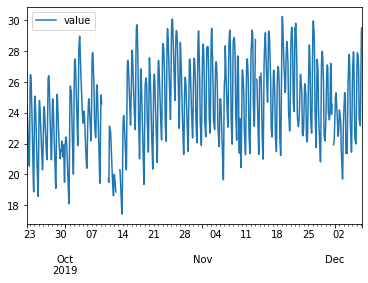

In [4]:
df_temp.plot()

# Differencing

In [5]:
df_diff = df_temp.diff().dropna()

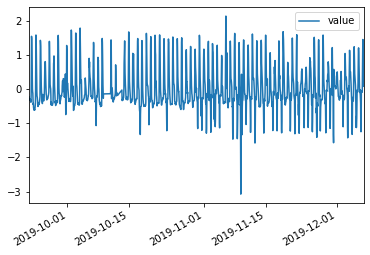

In [6]:
df_diff.plot()

# Stationarity Tests
## Augmented Dickey-Fuller Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

> Null Hypothesis (H0): Time Series is NOT stationary. 

**adf**: `float`

Test statistic

**pvalue**: `float`

MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)

**usedlag**: `int`

Number of lags used

**nobs**: `int`

Number of observations used for the ADF regression and calculation of the critical values

**critical values**: `dict`

Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)

**icbest**: `float`
The maximized information criterion if autolag is not None.

In [7]:
print("TEMPERATURE")
results = stattools.adfuller(df_temp['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

TEMPERATURE
p-value: 6.436493751080194e-05
Reject H0. Reject non-stationary. It could be stationary.


In [8]:
print("DIFFERENCED")
results = stattools.adfuller(df_diff['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

DIFFERENCED
p-value: 5.514603935793074e-15
Reject H0. Reject non-stationary. It could be stationary.


## KPSS Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html#statsmodels.tsa.stattools.kpss

> Null Hypothesis (H0): Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.

**kpss_stat**: `float`

The KPSS test statistic

**p_value**: `float`

The p-value of the test. The p-value is interpolated from Table 1 in Kwiatkowski et al. (1992), and a boundary point is returned if the test statistic is outside the table of critical values, that is, if the p-value is outside the interval (0.01, 0.1).

**lags**: `int`

The truncation lag parameter

**crit**: `dict`

The critical values at 10%, 5%, 2.5% and 1%. Based on Kwiatkowski et al. (1992).


In [9]:
print("TEMPERATURE")
results = stattools.kpss(df_temp['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

TEMPERATURE
p-value: 0.01
Reject H0. Reject stationary. It could be non-stationary.


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [10]:
print("DIFFERENCED")
results = stattools.kpss(df_diff['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

DIFFERENCED
p-value: 0.1
Could not reject H0. It is likely stationary.


c:\users\jpeak\projects\temperature-timeseries\.venv\lib\site-packages\statsmodels\tsa\stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


# Auto Correlation Plots

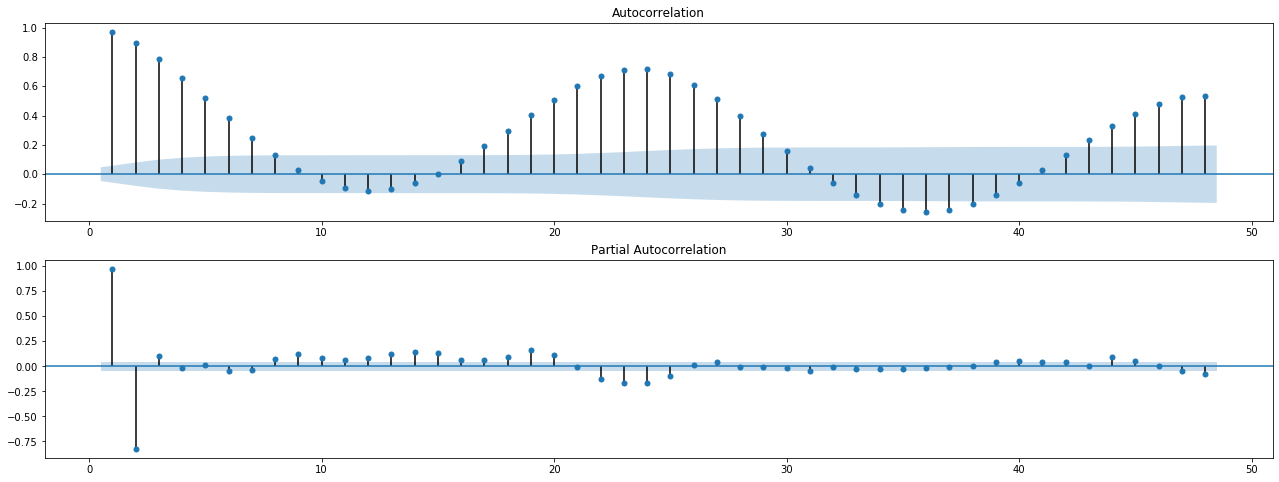

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(22,8))
plot_acf(df_temp.dropna(), lags=48, zero=False, ax=ax1)
plot_pacf(df_temp.dropna(), lags=48, zero=False, ax=ax2)
plt.show()

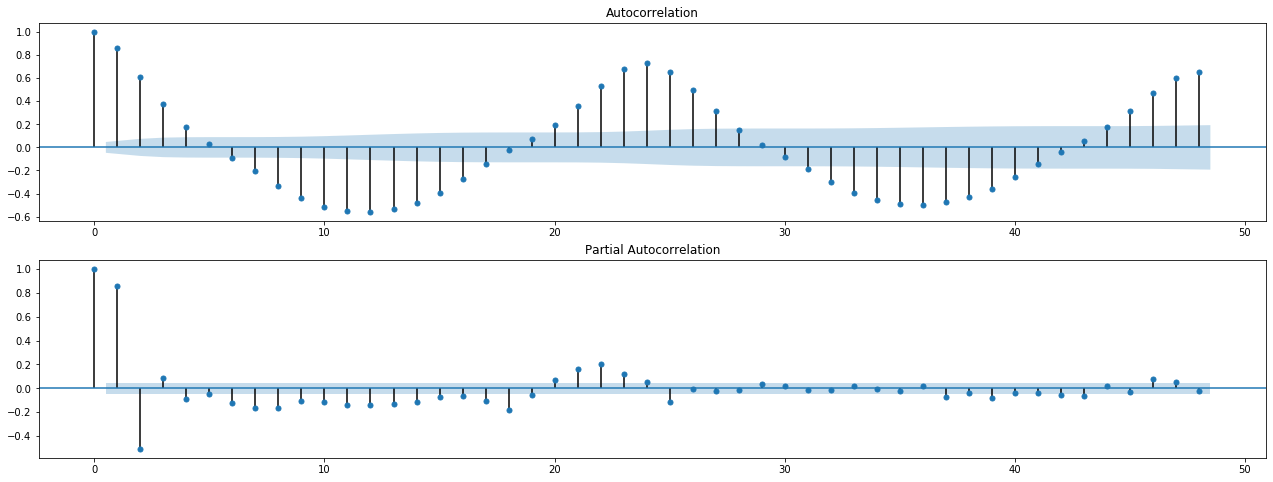

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(22,8))
plot_acf(df_diff.dropna(), lags=48, zero=True, ax=ax1)
plot_pacf(df_diff.dropna(), lags=48, zero=True, ax=ax2)
plt.show()

## ACF

The Auto Correlation Function, has strong correlation at lags 12, 24, 36 but overall decays slowly.

## PACF

The Partial Auto Correlation function drops off rapidly after 2 lags which suggests a strong Auto Regressive relationship. 

Lets look at fitting an ARIMA model next.

# ARIMA

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from itertools import product

# Setup list of experiments
pdqPDQS = list(
    product(
        product(range(0,5),[0,1],range(0,5), [0,12,24,36,48]),
        product(range(0,5),[1],range(0,5))
    )
)

print(len(pdqPDQS))
start = datetime.now()
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'))

# Define a fitting task
def fit_sarimax(pdqPDQS):
    non_seasonal = pdqPDQS[1]
    seasonal = pdqPDQS[0]
    try:
        model = SARIMAX(df_temp['value'], order=non_seasonal, seasonal_order=seasonal)
        results = model.fit()
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'), non_seasonal, seasonal, results.aic, results.bic)
        return (non_seasonal, seasonal, results.aic, results.bic)
    except:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'), non_seasonal, seasonal, None, None)
        return (non_seasonal, seasonal, None, None)
    
with ThreadPoolExecutor() as pool:
    order_aic_bic = pool.map(fit_sarimax, pdqPDQS)

/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


(0, 1, 0) (0, 0, 0, 0) 3181.468518205184 3186.951762621258
(0, 1, 0) (0, 0, 0, 12) 3181.468518205184 3186.951762621258
(0, 1, 0) (0, 0, 0, 48) 3181.468518205184 3186.951762621258
(0, 1, 0) (0, 0, 0, 36) 3181.468518205184 3186.951762621258
(0, 1, 0) (0, 0, 0, 24) 3181.468518205184 3186.951762621258
(0, 1, 0) (0, 1, 0, 12) 5096.544198976573 5102.020671357737
(0, 1, 0) (0, 1, 0, 24) 1677.6883996315223 1683.1580538044545
(0, 1, 0) (0, 0, 1, 0) 1516.0716767817282 1527.038165613876
(0, 1, 0) (0, 1, 0, 36) 4994.432621706963 4999.895410864376
(0, 1, 0) (0, 0, 1, 12) 2939.1519965129946 2950.1184853451423
(0, 1, 0) (1, 0, 0, 0) 904.24085314495 915.2073419770977
(0, 1, 0) (0, 1, 0, 48) 1880.9328056670397 1886.3886823545315
(0, 1, 0) (0, 0, 1, 24) 2383.3548240100954 2394.321312842243
(0, 1, 0) (0, 0, 2, 0) 747.4485652566628 763.8982985048845
(0, 1, 0) (1, 0, 0, 12) 2569.8283601269104 2580.794848959058
(0, 1, 0) (0, 0, 2, 12) 2250.820883498762 2267.2706167469837
(0, 1, 0) (0, 0, 4, 0) 424.271039941

/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


(0, 1, 0) (1, 1, 1, 36) 1787.5170821085378 1803.9054495807752
(0, 1, 0) (1, 0, 2, 24) 822.0201361062132 843.9531137705086
(0, 1, 0) (1, 0, 2, 48) 929.6019799940384 951.5349576583338
(0, 1, 0) (2, 0, 0, 24) 1300.389162532399 1316.8388957806205
(0, 1, 0) (0, 1, 4, 36) 2013.6869836748688 2041.000929461931
(0, 1, 0) (2, 0, 2, 0) 176.33614212681002 203.75236420717926


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0) (2, 0, 0, 48) 1310.8349957755984 1327.2847290238199
(0, 1, 0) (1, 0, 2, 36) 1451.547754805174 1473.4807324694693
(0, 1, 0) (1, 1, 2, 12) 826.7091732870995 848.6150628117551
(0, 1, 0) (1, 1, 2, 24) 785.8111896372452 807.6898063289738
(0, 1, 0) (2, 0, 0, 36) 1711.3015576396383 1727.7512908878598
(0, 1, 0) (1, 1, 0, 48) 1294.2725551160233 1305.184308491007
(0, 1, 0) (2, 0, 1, 12) 1333.6433506886422 1355.5763283529375
(0, 1, 0) (1, 0, 3, 24) 817.5663958400792 844.9826179204484


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0) (1, 0, 3, 36) 1415.4729131107083 1442.8891351910775
(0, 1, 0) (2, 0, 3, 0) 177.45695667274313 210.35642316918623
(0, 1, 0) (1, 0, 3, 48) 931.5330039904165 958.9492260707858
(0, 1, 0)(0, 1, 0) (1, 0, 4, 12) 1205.2475501834913  (2, 1, 0, 12) 1649.676999369055 1666.1064165125467
1238.1470166799345
(0, 1, 0) (2, 0, 2, 12) 822.2531661371423 849.6693882175116
(0, 1, 0) (1, 1, 2, 36) 1091.8447194990415 1113.6958761286912
(0, 1, 0) (2, 1, 0, 24) 1174.9394082935642 1191.3483708123606
(0, 1, 0) (1, 1, 3, 12) 808.9718865280093 836.3542484338288
(0, 1, 0) (2, 0, 1, 24) 823.0829626242871 845.0159402885826
(0, 1, 0) (2, 0, 1, 48) 930.0802732507938 952.0132509150892
(0, 1, 0) (1, 1, 1, 48) 859.0792461325991 875.4468761950745


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0) (1, 1, 2, 48) 860.9207120549175 882.7442188048849
(0, 1, 0) (2, 1, 0, 48) 1099.884611412329 1116.2522414748044
(0, 1, 0) (2, 0, 4, 0) 51.68858340851355 90.0712943210305
(0, 1, 0) (0, 1, 0)(2, 1, 0, 36) 1944.324123842902 1960.7124913151395
 (1, 0, 4, 24) 795.4266053685584 828.3260718650015
(0, 1, 0) (1, 0, 4, 36) 1351.2288278197993 1384.1282943162423
(0, 1, 0) (3, 0, 0, 0) 372.83944197198025 394.77241963627563
(0, 1, 0) (2, 1, 1, 12) 1213.9432285007852 1235.8491180254407
(0, 1, 0) (1, 0, 4, 48) 933.5025105576424 966.4019770540855
(0, 1, 0) (1, 1, 3, 48) 862.6602481269415 889.9396315644007
(0, 1, 0) (2, 1, 1, 24) 778.2429778209187 800.1215945126472
(0, 1, 0) (1, 1, 4, 48) 864.2125518136414 896.9478119385924
(0, 1, 0) (2, 0, 2, 36) 1046.044329541353 1073.460551621722
(0, 1, 0)(0, 1, 0) (1, 1, 4, 24) 761.9759473973475  (2, 0, 3, 12) 804.2678694538388 837.1673359502819
(0, 1, 0) 794.7938724349402
(3, 0, 1, 0) 364.0267282699835 391.44295035035276
(0, 1, 0) (2, 0, 1, 36) 1392.167540

/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0) (3, 0, 0, 36) 1694.664553762686 1716.5975314269813
(0, 1, 0) (3, 0, 0, 24) 1177.1059237410464 1199.0389014053417


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0) (1, 1, 4, 36) 1091.1300032584743 1123.9067382029489
(0, 1, 0) (1, 1, 3, 24) 776.9591322620635 804.3074031267241
(0, 1, 0) (2, 0, 2, 24) 823.5264631121768 850.942685192546
(0, 1, 0) (2, 1, 2, 48) 863.0228840183764 890.3022674558356
(0, 1, 0) (2, 1, 2, 12) 806.7350064239473 834.1173683297668


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0) (3, 0, 2, 0) 177.85679453522482 210.75626103166792
(0, 1, 0) (2, 1, 1, 36) 1565.8781035528705 1587.7292601825202
(0, 1, 0) (3, 0, 0, 48) 1144.3630768153434 1166.2960544796388


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0)(0, 1, 0) (2, 0, 2, 48) 931.5316287496706 (3, 0, 3, 0) 177.62092779209758 216.00363870461453
 958.9478508300399
(0, 1, 0) (2, 1, 2, 36) 1090.5327739955844 1117.8467197826467
(0, 1, 0) (3, 0, 1, 12) 1122.222037278569 1149.638259358938
(0, 1, 0) (2, 0, 3, 36) 1047.5528949721374 1080.4523614685804
(0, 1, 0)

/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 (2, 1, 2, 24) 766.4870728349993 793.8353436996599
(0, 1, 0) (3, 0, 2, 12) 802.0437258006391 834.9431922970822
(0, 1, 0) (3, 0, 4, 0) 340.67694355357116 384.542898882162


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0) (3, 0, 3, 12) 800.5134618324396 838.8961727449565
(0, 1, 0) (3, 1, 0, 12) 1340.6439252199307 1362.5498147445862
(0, 1, 0) (2, 0, 3, 24) 814.0520477166563 846.9515142130994
(0, 1, 0) (2, 0, 4, 12) 801.6653389857728 840.0480498982897
(0, 1, 0) (3, 1, 0, 24) 1003.6946971416853 1025.5733138334137
(0, 1, 0) (2, 1, 3, 12) 815.9121015796492 848.7709358666326


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0) (3, 0, 1, 48) 931.629590048696 959.0458121290652
(0, 1, 0) (3, 0, 1, 24) 814.5571548863795 841.9733769667488
(0, 1, 0) (2, 0, 3, 48) 931.9955586007948 964.8950250972379
(0, 1, 0) (3, 1, 0, 48) 965.7220371778749 987.5455439278422
(0, 1, 0) (3, 1, 0, 36) 1427.3833098955024 1449.2344665251521
(0, 1, 0) (4, 0, 0, 0) 353.24052793821886 380.6567500185881
(0, 1, 0) (3, 1, 1, 24) 765.1924251735047 792.5406960381654
(0, 1, 0) (2, 1, 4, 24) 762.119557801174 800.4071370116989
(0, 1, 0) (2, 0, 4, 36) 1034.9099741432462 1073.2926850557633


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0) (2, 1, 4, 12) 811.1465427564034 849.4818494245508
(0, 1, 0) (2, 1, 3, 48) 864.49955090925 897.234811034201
(0, 1, 0) (3, 1, 1, 12) 1086.4237617762806 1113.8061236821002


/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(0, 1, 0) (2, 0, 4, 24) 805.6895020064283(0, 1, 0) (2, 1, 3, 36) 1056.0115300390767 1088.7882649835512
 844.0722129189452
(0, 1, 0) (3, 0, 1, 36) 1325.2361336408171 1352.6523557211863


In [30]:
order_df = pd.DataFrame(order_aic_bic, columns=['pdq','PDQS','aic', 'bic'])
pdq, PDQS, aic, bic = order_df.sort_values('aic').iloc[0]
pdq, PDQS

(2.0, 4.0)

In [32]:
model = SARIMAX(df_temp['value'], order=pdq, seasonal_order=PDQS)
results = model.fit()
results.summary()

/Users/jpeak/projects/temperature-timeseries/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  value   No. Observations:                 1779
Model:               SARIMAX(2, 1, 4)   Log Likelihood                 -18.844
Date:                Fri, 06 Dec 2019   AIC                             51.689
Time:                        04:46:59   BIC                             90.071
Sample:                    09-22-2019   HQIC                            65.866
                         - 12-05-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9104      0.005    381.151      0.000       1.901       1.920
ar.L2         -0.9771      0.005   -203.951      0.000      -0.986      -0.968
ma.L1         -0.8044      0.015    -53.108      0.000      -0.834      -0.775
ma.L2         -0.5963      0.021    -28.998      0.000      -0.637      -0.556
ma.L3          0.0543      0.024      2.274      0.023       0.007       0.101
ma.L4          0.4600      0.017     27.164      0.000       0.427       0.493
sigma2         0.0597      0.001     51.458      0.000       0.057       0.062
===================================================================================
Ljung-Box (Q):                      454.96   Jarque-Bera (JB):              5768.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

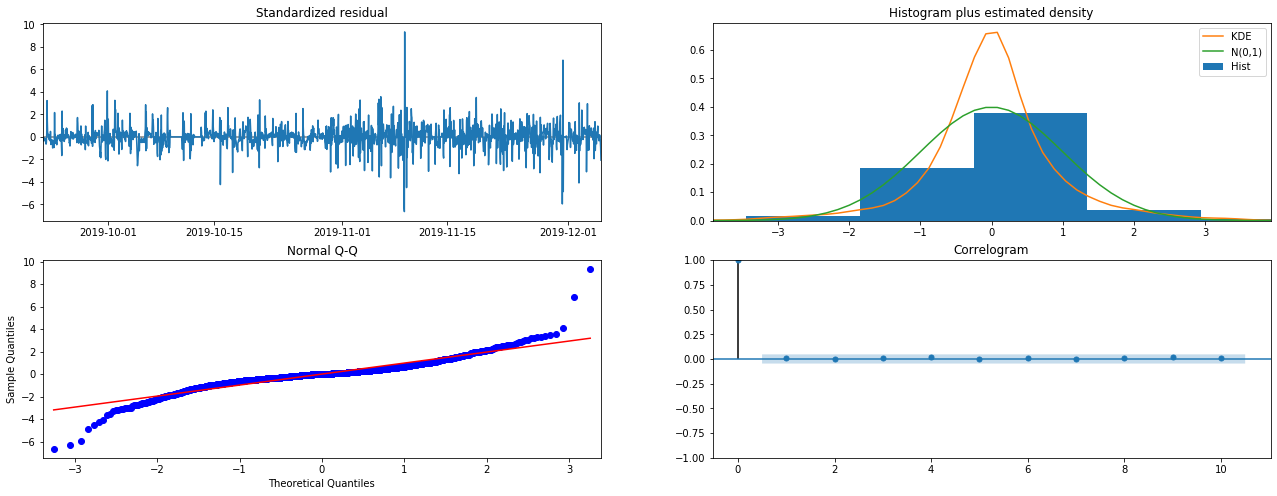

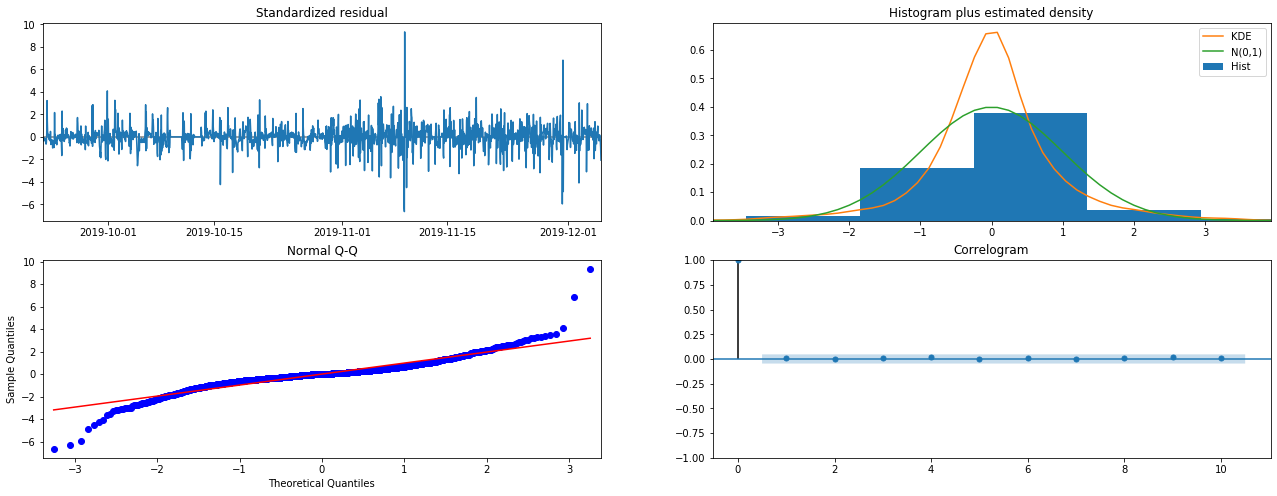

In [24]:
results.plot_diagnostics(figsize=(22,8))

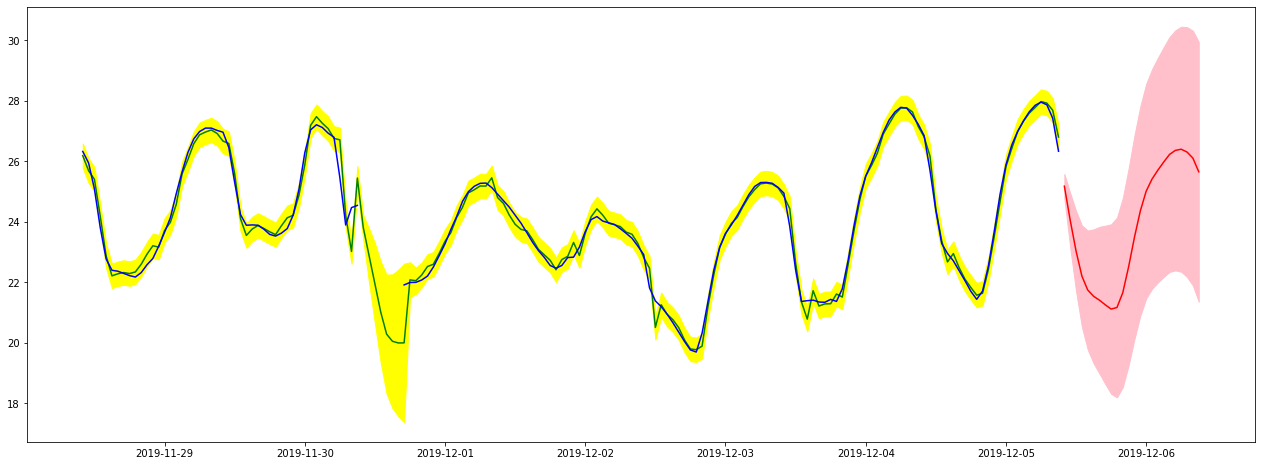

In [20]:
actual = df_temp[-168:]

prediction = results.get_prediction(start=-168, dynamic=False)
prediction_mean = prediction.predicted_mean
prediction_ci = prediction.conf_int()

forecast = results.get_forecast(steps=24, dynamic=True)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(22,8))



plt.plot(
    prediction_mean.index, 
    prediction_mean.values, 
    color='green', 
    label='prediction'
)
plt.fill_between(
    prediction_ci.index, 
    prediction_ci['lower value'], 
    prediction_ci['upper value'], 
    color='yellow'
)

plt.plot(
    forecast_mean.index, 
    forecast_mean.values, 
    color='red', 
    label='forecast'
)
plt.fill_between(
    forecast_ci.index, 
    forecast_ci['lower value'], 
    forecast_ci['upper value'], 
    color='pink'
)

plt.plot(
    actual.index,
    actual['value'],
    color='blue', 
    label='actual'
)

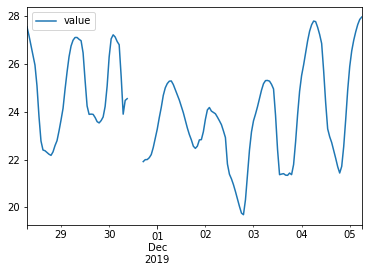

In [51]:
df_temp[-168:].plot()